In [1]:
import xgboost
import pandas as pd
import datetime

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,id,date,speed
0,0,1/1/2017 0:00,43.002930
1,1,1/1/2017 1:00,46.118696
2,2,1/1/2017 2:00,44.294158
3,3,1/1/2017 3:00,41.067468
4,4,1/1/2017 4:00,46.448653


In [4]:
test_data.head()

,id,date
0,0,1/1/2018 2:00
1,1,1/1/2018 5:00
2,2,1/1/2018 7:00
3,3,1/1/2018 8:00
4,4,1/1/2018 10:00


In [5]:
train_data["date"] = train_data["date"].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M"))
test_data["date"] = test_data["date"].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M"))

In [6]:
train_data["year"] = train_data["date"].apply(lambda x: x.year)
train_data["month"] = train_data["date"].apply(lambda x: x.month)
train_data["day"] = train_data["date"].apply(lambda x: x.day)
train_data["hour"] = train_data["date"].apply(lambda x: x.hour)
train_data["weekday"] = train_data["date"].apply(lambda x: x.weekday()+1)
#train_data["minute"] = train_data["date"].apply(lambda x: x.minute)
########
test_data["year"] = test_data["date"].apply(lambda x: x.year)
test_data["month"] = test_data["date"].apply(lambda x: x.month)
test_data["day"] = test_data["date"].apply(lambda x: x.day)
test_data["hour"] = test_data["date"].apply(lambda x: x.hour)
test_data["weekday"] = test_data["date"].apply(lambda x: x.weekday()+1)

In [7]:
holiday_2017_2018 = ["2017-01-01","2017-01-02","2017-01-28","2017-01-30","2017-01-31","2017-04-04","2017-04-14","2017-04-15","2017-04-17","2017-05-01","2017-05-03","2017-05-30","2017-07-01","2017-10-01","2017-10-02","2017-10-05","2017-10-04","2017-10-28","2017-12-25","2017-12-26","2018-01-01","2018-02-16","2018-02-17","2018-02-19","2018-03-30","2018-03-31","2018-04-02","2018-04-05","2018-05-01","2018-05-22","2018-06-18","2018-07-01","2018-07-02","2018-09-24","2018-09-25","2018-10-01","2018-10-17","2018-12-25", "2018-12-26"]
holiday_2018 = ["2018-01-01","2018-02-16","2018-02-17","2018-02-19","2018-03-30","2018-03-31","2018-04-02","2018-04-05","2018-05-01","2018-05-22","2018-06-18","2018-07-01","2018-07-02","2018-09-24","2018-09-25","2018-10-01","2018-10-17","2018-12-25", "2018-12-26"]

In [8]:
#Holiday 
def holiday_or_not(data,holiday):
    if data.strftime("%Y-%m-%d") in holiday:
        return 1
    else:
        return 0
train_data["holiday"] = train_data["date"].apply(lambda x: holiday_or_not(x,holiday_2017_2018))
test_data["holiday"] = test_data["date"].apply(lambda x: holiday_or_not(x,holiday_2018))

In [9]:
#morning afternoon night latenight
def manl_label(data):
    if data.hour >=0 and data.hour < 7:
        return 0
    elif data.hour >= 7 and data.hour < 10:
        return 1
    elif data.hour >= 10 and data.hour < 14:
        return 2
    elif data.hour >= 14 and data.hour < 17:
        return 3
    elif data.hour >= 17 and data.hour < 21:
        return 4
    elif data.hour >= 21 and data.hour < 24:
        return 5
train_data["period"] = train_data["date"].apply(lambda x: manl_label(x))
test_data["period"] = test_data["date"].apply(lambda x: manl_label(x))

In [10]:
#weather
weather_data = pd.read_csv("hongkong.csv")
weather_data["date_time"] = weather_data["date_time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [11]:
join_data = train_data.set_index('date').join(weather_data.set_index('date_time'))
join_test = test_data.set_index('date').join(weather_data.set_index('date_time'))

In [12]:
join_data.head()

,id,speed,year,month,day,hour,weekday,holiday,period,maxtempC,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0,43.002930,2017,1,1,0,7,1,0,21,...,32,44,86,0.0,1022,17,10,71,19,hongkong
2017-01-01 01:00:00,1,46.118696,2017,1,1,1,7,1,0,21,...,32,35,86,0.0,1022,17,10,69,20,hongkong
2017-01-01 02:00:00,2,44.294158,2017,1,1,2,7,1,0,21,...,32,27,87,0.0,1022,17,10,66,20,hongkong
2017-01-01 03:00:00,3,41.067468,2017,1,1,3,7,1,0,21,...,32,18,87,0.0,1022,17,10,64,20,hongkong
2017-01-01 04:00:00,4,46.448653,2017,1,1,4,7,1,0,21,...,31,22,86,0.0,1022,17,10,65,20,hongkong


In [13]:
join_data.head()

,id,speed,year,month,day,hour,weekday,holiday,period,maxtempC,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0,43.002930,2017,1,1,0,7,1,0,21,...,32,44,86,0.0,1022,17,10,71,19,hongkong
2017-01-01 01:00:00,1,46.118696,2017,1,1,1,7,1,0,21,...,32,35,86,0.0,1022,17,10,69,20,hongkong
2017-01-01 02:00:00,2,44.294158,2017,1,1,2,7,1,0,21,...,32,27,87,0.0,1022,17,10,66,20,hongkong
2017-01-01 03:00:00,3,41.067468,2017,1,1,3,7,1,0,21,...,32,18,87,0.0,1022,17,10,64,20,hongkong
2017-01-01 04:00:00,4,46.448653,2017,1,1,4,7,1,0,21,...,31,22,86,0.0,1022,17,10,65,20,hongkong


In [14]:
train_data = train_data.reset_index(drop=True)
join_data = join_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
join_test = join_data.reset_index(drop=True)

train_data["tempC"] = join_data["tempC"]
train_data["visibility"] = join_data["visibility"]
train_data["windspeedKmph"] = join_data["windspeedKmph"]
train_data["WindGustKmph"] = join_data["WindGustKmph"]
train_data["cloudcover"] = join_data["cloudcover"]
train_data["winddirDegree"] = join_data["winddirDegree"]
train_data["FeelsLikeC"] = join_data["FeelsLikeC"]
train_data["HeatIndexC"] = join_data["HeatIndexC"]
#
test_data["tempC"] = join_test["tempC"]
test_data["visibility"] = join_test["visibility"]
test_data["windspeedKmph"] = join_test["windspeedKmph"]
test_data["WindGustKmph"] = join_test["WindGustKmph"]
test_data["cloudcover"] = join_test["cloudcover"]
test_data["winddirDegree"] = join_test["winddirDegree"]
test_data["FeelsLikeC"] = join_test["FeelsLikeC"]
test_data["HeatIndexC"] = join_test["HeatIndexC"]

In [15]:
# friday saturday sunday 
def fsa_or_not(x):
    if x == 5 or x == 6 or x == 7:
        return 1
    else:
        return 0
train_data["fsa"] = train_data["date"].apply(lambda x: fsa_or_not(x))
test_data["fsa"] = test_data["date"].apply(lambda x: fsa_or_not(x))

In [16]:
train_data.head()

,id,date,speed,year,month,day,hour,weekday,holiday,period,tempC,visibility,windspeedKmph,WindGustKmph,cloudcover,winddirDegree,FeelsLikeC,HeatIndexC,fsa
0,0,2017-01-01 00:00:00,43.002930,2017,1,1,0,7,1,0,17,10,19,32,44,71,17,17,0
1,1,2017-01-01 01:00:00,46.118696,2017,1,1,1,7,1,0,17,10,20,32,35,69,17,17,0
2,2,2017-01-01 02:00:00,44.294158,2017,1,1,2,7,1,0,17,10,20,32,27,66,17,17,0
3,3,2017-01-01 03:00:00,41.067468,2017,1,1,3,7,1,0,17,10,20,32,18,64,17,17,0
4,4,2017-01-01 04:00:00,46.448653,2017,1,1,4,7,1,0,17,10,20,31,22,65,17,17,0


In [17]:
test_data.head()

,id,date,year,month,day,hour,weekday,holiday,period,tempC,visibility,windspeedKmph,WindGustKmph,cloudcover,winddirDegree,FeelsLikeC,HeatIndexC,fsa
0,0,2018-01-01 02:00:00,2018,1,1,2,1,1,0,17,10,19,32,44,71,17,17,0
1,1,2018-01-01 05:00:00,2018,1,1,5,1,1,0,17,10,20,32,35,69,17,17,0
2,2,2018-01-01 07:00:00,2018,1,1,7,1,1,1,17,10,20,32,27,66,17,17,0
3,3,2018-01-01 08:00:00,2018,1,1,8,1,1,1,17,10,20,32,18,64,17,17,0
4,4,2018-01-01 10:00:00,2018,1,1,10,1,1,2,17,10,20,31,22,65,17,17,0


In [18]:
train_data.drop(["date"], axis = 1, inplace=True)
train_data.drop(["id"], axis = 1, inplace=True)
#train_data.drop(["year"], axis = 1, inplace=True)

test_data.drop(["date"], axis = 1, inplace=True)
test_data.drop(["id"], axis = 1, inplace=True)
#test_data.drop(["year"], axis = 1, inplace=True)

In [19]:
train_data.head()

,speed,year,month,day,hour,weekday,holiday,period,tempC,visibility,windspeedKmph,WindGustKmph,cloudcover,winddirDegree,FeelsLikeC,HeatIndexC,fsa
0,43.002930,2017,1,1,0,7,1,0,17,10,19,32,44,71,17,17,0
1,46.118696,2017,1,1,1,7,1,0,17,10,20,32,35,69,17,17,0
2,44.294158,2017,1,1,2,7,1,0,17,10,20,32,27,66,17,17,0
3,41.067468,2017,1,1,3,7,1,0,17,10,20,32,18,64,17,17,0
4,46.448653,2017,1,1,4,7,1,0,17,10,20,31,22,65,17,17,0


In [20]:
y_train = train_data["speed"]

In [21]:
x_train = train_data[['year','month','fsa','day','hour','weekday','holiday','visibility','period','tempC','windspeedKmph','WindGustKmph','cloudcover','winddirDegree','HeatIndexC','FeelsLikeC']]

In [22]:
x_train.head()

,year,month,fsa,day,hour,weekday,holiday,visibility,period,tempC,windspeedKmph,WindGustKmph,cloudcover,winddirDegree,HeatIndexC,FeelsLikeC
0,2017,1,0,1,0,7,1,10,0,17,19,32,44,71,17,17
1,2017,1,0,1,1,7,1,10,0,17,20,32,35,69,17,17
2,2017,1,0,1,2,7,1,10,0,17,20,32,27,66,17,17
3,2017,1,0,1,3,7,1,10,0,17,20,32,18,64,17,17
4,2017,1,0,1,4,7,1,10,0,17,20,31,22,65,17,17


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'gamma': 0,
    'max_depth': 80,
    'lambda': 3,
    'subsample': 0.4,
    'colsample_bytree': 1,
    'min_child_weight': 0,
    'silent': 0,
    'eta': 0.01,
}
'''params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'gamma': 0,
    'max_depth': 60,
    'lambda': 3,
    'subsample': 0.5,
    'colsample_bytree': 1,
    'min_child_weight': 0,
    'silent': 0,
    'eta': 0.01,
    'seed': 1000,
    'nthread': 4
}
'''


"params = {\n    'booster': 'gbtree',\n    'objective': 'reg:squarederror',\n    'gamma': 0,\n    'max_depth': 60,\n    'lambda': 3,\n    'subsample': 0.5,\n    'colsample_bytree': 1,\n    'min_child_weight': 0,\n    'silent': 0,\n    'eta': 0.01,\n    'seed': 1000,\n    'nthread': 4\n}\n"

In [29]:
train_xg = xgboost.DMatrix(X_train, Y_train)
num_rounds = 1500
param_list = list(params.items())
model = xgboost.train(param_list, train_xg, num_rounds)

[22:45:37] WARNING: /Users/jimmy233/Desktop/msbd-5012/group_project/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [30]:
from sklearn import metrics
testPred = model.predict(xgboost.DMatrix(X_test))

print("MSE:",metrics.mean_squared_error(Y_test, testPred))

MSE: 11.290942196855692


In [31]:
from xgboost import plot_importance

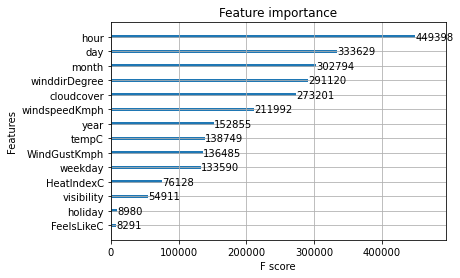

In [32]:
plot_importance(model)

In [33]:
model_train = xgboost.DMatrix(x_train, y_train)
num_rounds = 2000
model_predict = xgboost.train(param_list, model_train, num_rounds)

[22:48:37] WARNING: /Users/jimmy233/Desktop/msbd-5012/group_project/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [34]:
test = test_data[['year','month','fsa','day','hour','weekday','holiday','visibility','period','tempC','windspeedKmph','WindGustKmph','cloudcover','winddirDegree','HeatIndexC','FeelsLikeC']]
result = model_predict.predict(xgboost.DMatrix(test))
submission = pd.read_csv("sampleSubmission.csv")
submission.drop(["speed"], axis = 1, inplace=True)

In [35]:
submission['speed'] = result

In [36]:
submission.head()

,id,speed
0,0,46.962139
1,1,46.469673
2,2,34.764149
3,3,24.444780
4,4,32.312569


In [180]:
submission.to_csv("result_8.csv",index = False)